In [1]:
## Analytical Placement Toy ##

In [2]:
# Step 0-1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


In [21]:
# Step 0-2: Define Parameters
GAMMA = 1.0
LR    = 0.5
ITER  = 100

In [22]:
class Netlist:
    def __init__(self):
        self.cells_name = []
        self.cells_size = []
        self.cells_pos  = [] # pos is center of cell
        self.nets       = []

In [23]:
# Test Case
# Assume we have 5 cells and 4 nets connecting them
board_size = 32
netlist = Netlist()
netlist.cells_name = ['A', 'B', 'C', 'D', 'E', 'F']
netlist.cells_size = np.array([[3,3], [3,3], [1,2], [2,1], [1,1], [1,1]])
netlist.cells_pos = np.zeros((len(netlist.cells_name), 2))
netlist.nets = np.array([[0, 1], [1, 2], [2, 3], [3, 4], [4, 5]])
#nets = [[2,4,5],[0,1,3],[0,2,3,5],[0,1,2,3,4]]

In [24]:
# Step 2: Define Util Functions
# Visualize Initial and Optimized Placements
def plot_placement(ax, netlist, iteration, total_hpwl):
    ax.clear()
    for net in netlist.nets:
        net_cells = netlist.cells_pos[net]
        ax.plot(net_cells[:, 0], net_cells[:, 1], 'r--', alpha=0.5)  # Draw nets
    ax.scatter(netlist.cells_pos[:, 0], netlist.cells_pos[:, 1], color='blue', s=50, label='Cells')
    ax.set_xlim(0, board_size)
    ax.set_ylim(0, board_size)
    ax.set_title(f'Placement at Iteration {iteration}, HPWL: {total_hpwl:.2f}')
    # ax.legend()
    ax.grid(True)
# Initialize Placement
def initialize_placement(num_cells, board_size):
    np.random.seed(666)  # For reproducibility
    cells = np.random.rand(num_cells, 2) * board_size  # Random positions within the canvas
    return cells

In [25]:
# Initialize random positions for cells (2D positions: x, y)
np.random.seed(666)  # For reproducibility
init_pos = initialize_placement(len(netlist.cells_name), board_size)

In [ ]:
# Step 3: Define Objective Function
# Wirelength as the Log-Sum-Exp HPWL 
def log_sum_exp_hpwl(positions, nets, gamma=1.0):
    # wl_x = r * sum( ln(sum( exp(x_k/r) )) - ln(sum( exp(-x_k/r) )) )    ### max(x) - min(x)
    total_hpwl = 0.0
    for net in nets:
        xs = positions[net, 0]
        ys = positions[net, 1]
        wl_x = gamma * ( np.log(np.sum(np.exp(xs / gamma))) + np.log(np.sum(np.exp(-xs / gamma))) )
        wl_y = gamma * ( np.log(np.sum(np.exp(ys / gamma))) + np.log(np.sum(np.exp(-ys / gamma))) )
        total_hpwl += wl_x + wl_y
    return total_hpwl
def hpwl(positions, nets):
    # HPWL_x = max(x) - min(x)
    hpwl = 0
    for cell_ids in nets: # for each net
        x_coords = positions[cell_ids, 0]
        y_coords = positions[cell_ids, 1]
        hpwl += (x_coords.max() - x_coords.min()) + (y_coords.max() - y_coords.min())
    return hpwl

In [ ]:
# Step 4: Gradient Descent Optimization
# Gradient descent to minimize objective function
def calculate_wl_gradient(netlist, gamma=1.0):
    cells = netlist.cells_pos; nets = netlist.nets
    grad = np.zeros_like(cells) # gradient
    for cell_ids in nets: # for each net
        xs = cells[cell_ids, 0]
        ys = cells[cell_ids, 1]
        exp_xs = np.exp(xs / gamma)       # max(x)
        exp_neg_xs = np.exp(-xs / gamma)  # -min(x)
        exp_ys = np.exp(ys / gamma)       # max(y)
        exp_neg_ys = np.exp(-ys / gamma)  # -min(y)

        grad_xs = gamma * ( (exp_xs / np.sum(exp_xs)) - (exp_neg_xs / np.sum(exp_neg_xs)) ) # partial derivative for each x_i
        grad_ys = gamma * ( (exp_ys / np.sum(exp_ys)) - (exp_neg_ys / np.sum(exp_neg_ys)) )

        grad[cell_ids, 0] += grad_xs
        grad[cell_ids, 1] += grad_ys
    return grad
# Update cell positions using gradient descent
def update_positions(cells_pos, gradient, learning_rate=0.1):
    cells_pos -= learning_rate * gradient
    return cells_pos

In [28]:
def plot_placement(ax, netlist, iteration, total_hpwl):
    ax.clear()
    for net in netlist.nets:
        net_cells = netlist.cells_pos[net]
        ax.plot(net_cells[:, 0], net_cells[:, 1], 'r--', alpha=0.5)  # Draw nets

    for i, (pos, size) in enumerate(zip(netlist.cells_pos, netlist.cells_size)):
        rect = plt.Rectangle(pos - size / 2, size[0], size[1], edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
        ax.text(pos[0], pos[1], netlist.cells_name[i], ha='center', va='center', fontsize=8, color='blue')

    ax.set_xlim(0, board_size)
    ax.set_ylim(0, board_size)
    ax.set_title(f'Placement at Iteration {iteration}, HPWL: {total_hpwl:.2f}')
    ax.grid(True)

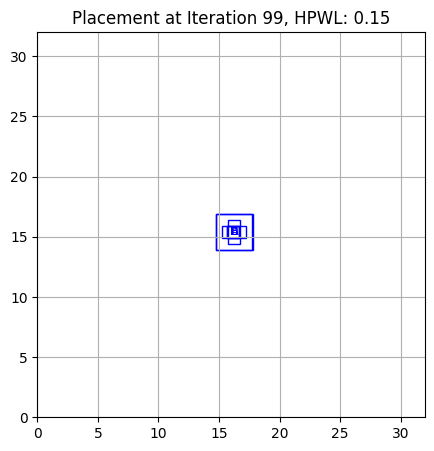

In [55]:
## Main analytical placement function ## 
# Initialize cells positions and parameters
netlist.cells_pos = init_pos.copy()
num_iter = ITER
gamma = GAMMA
step_size = LR

fig, ax = plt.subplots(figsize=(5, 5))
# Iteratively optimize placement
for iter in range(num_iter):
    # Calculate wirelength
    total_hpwl = hpwl(netlist.cells_pos, netlist.nets)
    total_lse = log_sum_exp_hpwl(netlist.cells_pos, netlist.nets, gamma=gamma)
    # print(f'\rIteration {iter}: LSE Wirelength = {total_hpwl:.2f}', end='')

    # Calculate gradient
    gradient = calculate_wl_gradient(netlist)
    # Update positions
    netlist.cells_pos = update_positions(netlist.cells_pos, gradient, learning_rate=step_size)

    # Plot placement
    plot_placement(ax, netlist, iter, total_hpwl)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.01)

## Better Gradient Descent

In [43]:
# CG (conjugate gradient) with Dynemic Step Size
# Update cell positions
def update_positions_cg(cells_pos, g_prev, d_prev, grad, step_size=1.0):
    # (1) We have gradient directions grad = g_k = ∇f(x_k)
    # (2) Compute Polak-Ribiere parameter β_k (make history grad have bigger ratio if gradient differ too much)
    beta = np.sum(grad * (grad - g_prev), axis=1) / (np.sum(g_prev**2, axis=1) + 1e-10)
    beta = np.clip(beta, 0, None)  # make sure β_k >= 0
    # (3) Compute conjugate directions d = -grad + beta*d_prev
    dir = -grad + beta[:, None] * d_prev # d_prev.shape = (N, 2)
    # (4) Compute step size alpha = s/norm(d)
    alpha = step_size / (np.linalg.norm(dir, axis=1) + 1e-10) # small d --> big step, big d --> small step (improve convergence)
    # (5) update positions: x = x_prev + alpha*d
    cells_pos += (alpha[:, None] * dir)
    return cells_pos, dir

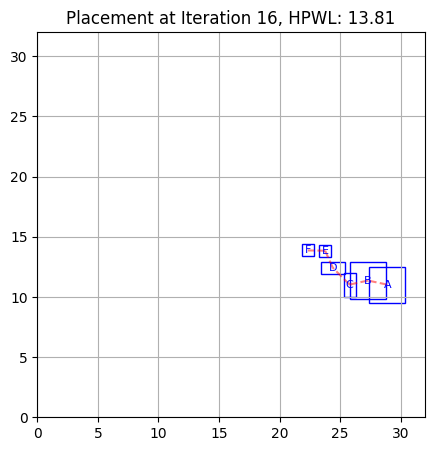

In [56]:
## Main analytical placement function ## 
# Initialize cells positions and parameters
netlist.cells_pos = init_pos.copy()
num_iter = ITER
gamma = GAMMA
step_size = board_size / 20

fig, ax = plt.subplots(figsize=(5, 5))

g_prev = np.zeros_like(netlist.cells_pos)  # init grad = 0
d_prev = np.zeros_like(netlist.cells_pos)  # init dir = 0
early_stop = False
# Iteratively optimize placement
for iter in range(num_iter):
    # Calculate wirelength
    total_hpwl = hpwl(netlist.cells_pos, netlist.nets)
    total_lse = log_sum_exp_hpwl(netlist.cells_pos, netlist.nets, gamma=gamma)
    # print(f'\rIteration {iter}: LSE Wirelength = {total_hpwl:.2f}', end='')

    # Calculate gradient
    gradient = calculate_wl_gradient(netlist)
    # Update positions
    netlist.cells_pos, dk = update_positions_cg(netlist.cells_pos, g_prev, d_prev, gradient, step_size=step_size)
    if iter > 15 and np.linalg.norm(gradient) > np.linalg.norm(g_prev):
        # print(f'Converged at iteration {iter}')
        early_stop = True
    g_prev = gradient.copy(); d_prev = dk.copy()


    # Plot placement
    plot_placement(ax, netlist, iter, total_hpwl)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.01)

    if early_stop:
        break